# STA365 HW8
## Lisa Wang

### Q1
**Question:** 

- For a binary outcome dataset you find interesting (perhaps from kaggle.com?)
- Model the outcome as a bernoulli random variable and use a **logit link** function
- Use `pm.Normal('betas', mu=0, sigma=1, shape=p)` rather than the `pm.MvNormal` version
- Provide inference with Bayesian posterior analysis and report MCMC diagnostics

**Answer:**

In this analysis, I apply Bayesian logistic regression to examine the relationship between BMI, SleepTime, and the probability of being diabetic. The goal is to determine how these predictors influence diabetes risk.

Model equation:

$P(\text{Diabetic} = 1) = \frac{1}{1 + \exp(-X\beta)}$

where X represents the selected predictors (BMI and SleepTime), and $\beta$ represents their estimated effects.

In [11]:
import pandas as pd  
import numpy as np  
import pymc as pm  
import arviz as az  
import matplotlib.pyplot as plt  

# Load the dataset 
df = pd.read_csv("cleaned_data_HW8.csv")  

# Set random seed 
np.random.seed(42)

# Randomly sample 5000 rows from the dataset
df_sampled = df.sample(n=5000, random_state=42)

# Keep only BMI and SleepTime as predictors
df_sampled = df_sampled[["BMI", "SleepTime", "Diabetic"]]

# Separate predictors and outcome
X = df_sampled.drop(columns=["Diabetic"])
y = df_sampled["Diabetic"]

# Standardize continuous predictors
X = (X - X.mean()) / X.std()

# Convert to NumPy arrays for PyMC
X = np.asarray(X, dtype=np.float32)
y = np.asarray(y, dtype=np.int32)  # Ensure y is integer for Bernoulli

In [12]:
# Build regression model

# Get the number of predictors
n_predictors = X.shape[1]

with pm.Model() as logistic_model:
    # Priors for regression coefficients
    betas = pm.Normal("betas", mu=0, sigma=1, shape=n_predictors)
    
    # Linear combination
    logit_p = pm.math.dot(X, betas)
    
    # Likelihood function (Bernoulli with logit link)
    y_obs = pm.Bernoulli("y_obs", logit_p=logit_p, observed=y)
    
    # Sample from the posterior
    trace = pm.sample(1000, tune=500, target_accept=0.9, cores=2, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [betas]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 51 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


**Posterior Analysis & MCMC Diagnostics**

In [14]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[0],0.333,0.031,0.274,0.391,0.001,0.001,2243.0,1238.0,1.00
betas[1],0.021,0.029,-0.030,0.077,0.001,0.001,1952.0,1365.0,1.01


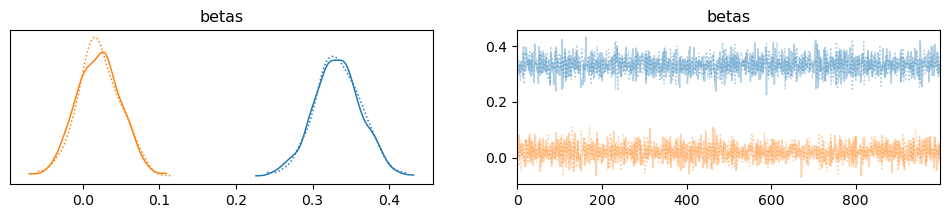

In [15]:
az.plot_trace(trace)
plt.show()

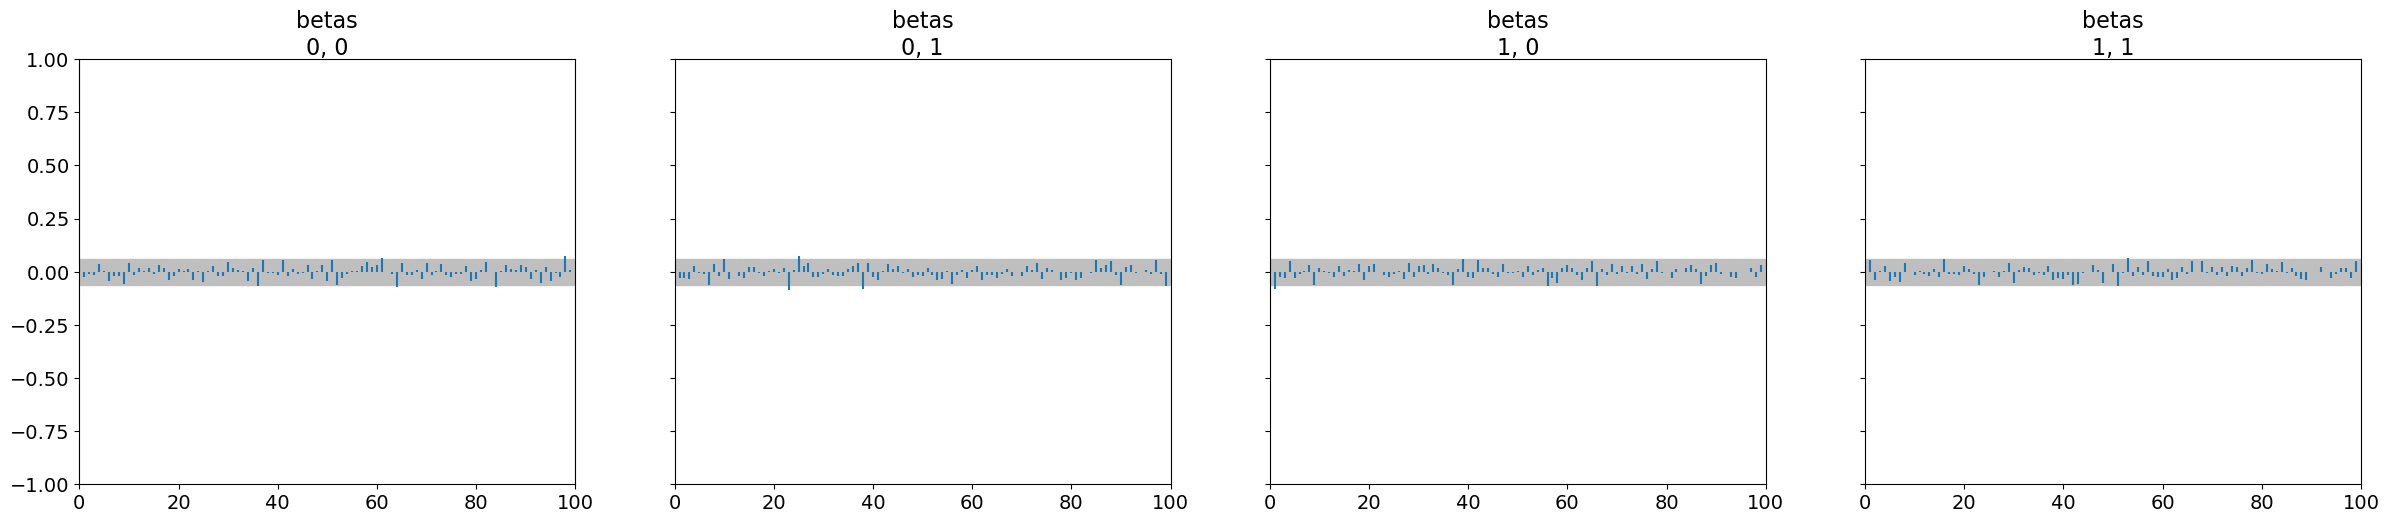

In [16]:
# check autocorrelation of samples
az.plot_autocorr(trace, var_names=["betas"])
plt.show()

The Bayesian logistic regression model helps us identify the relationship between BMI, SleepTime, and the probability of being diabetic. The posterior means represent the estimated effects of each predictor, while the highest density intervals (HDI) indicate uncertainty.

BMI ($\beta_1$ =0.333) has a positive effect on the probability of being diabetic, with a credible interval [0.274, 0.391]. Since the interval does not include zero, we have strong evidence that a higher BMI is associated with an increased risk of diabetes.

SleepTime ($\beta_2$ =0.021) has a very weak effect, with a credible interval [-0.030, 0.077] that overlaps zero. This suggests that SleepTime may have little to no impact on diabetes risk.

The R-hat values (~1.00) confirm that the chains have mixed well, indicating good convergence. The Effective Sample Size (ESS) is sufficiently large (> 1000), showing that the sampling process is efficient and reliable. Trace plots show well-mixed chains, and autocorrelation plots confirm minimal correlation between samples.

The results suggest that BMI is a significant predictor of diabetes, with higher BMI increasing the probability of being diabetic. However, SleepTime does not appear to have a meaningful effect, as its credible interval overlaps zero.

### Q2
**Question:** 

- For a data set for which modeling multiple continuous outcomes might be interesting (perhaps from kaggle.com?)
- Use `pm.Normal('betas', mu=0, sigma=1, shape=(p,m))` rather than a `pm.MvNormal` alternative
- Use `y = pm.MvNormal('y', mu=X@betas, chol=L, observed=x)` for `(n,m)` shaped `y` and `(n,p)` shaped `X`
- Downsample your dataset to tentatively explore the effect of different values of `n`,`m`,`p` and 
    - report on your findings and based on that 
    - choose a "reasonably small" sized data set to perform an actual analysis
- Provide inference with Bayesian posterior analysis and report MCMC diagnostics

**Answer:**

In [43]:
# Load the dataset (same dataset as HW7)
dfq2 = pd.read_csv("cleaned_data_HW7.csv")  

# Define multivariate outcome variables
y_columns = ["Price", "Weight"]  

# Define predictor variables
X_columns = ["Inches", "Ram"]  

# Extract data
y_data = dfq2[y_columns].values  
X_data = dfq2[X_columns].values  

In [45]:
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
import time

# Load the dataset (use your local path if needed)
dfq2 = pd.read_csv("cleaned_data_HW7.csv")

# Define multivariate outcome variables (continuous outcomes)
y_columns = ["Price", "Weight"]  

# Define predictor variables (features)
X_columns = ["Inches", "Ram"]  

# Extract data
y_data = dfq2[y_columns].values  # Shape (n, m) where m=2
X_data = dfq2[X_columns].values  # Shape (n, p) where p=2

# Standardize predictors
X_data = (X_data - X_data.mean(axis=0)) / X_data.std(axis=0)

# Define dataset sizes for downsampling
sample_sizes = [100, 500, 1000]

# Store results for different dataset sizes
results = []

for n in sample_sizes:
    # Sample a smaller dataset
    df_sampled = dfq2.sample(n=n, random_state=42)

    # Extract sampled predictors and outcomes
    X = df_sampled[X_columns].values
    y = df_sampled[y_columns].values

    # Standardize predictors
    X = (X - X.mean(axis=0)) / X.std(axis=0)

    # Convert to NumPy arrays
    X = np.asarray(X, dtype=np.float32)
    y = np.asarray(y, dtype=np.float32)

    # Define shapes
    n, m = y.shape  # Number of observations and outcomes
    p = X.shape[1]  # Number of predictors

    # Track time
    start_time = time.time()

    # Build Bayesian Multivariate Regression Model
    with pm.Model() as multivariate_regression:
        # Latent correlation structure using LKJ prior
        L, R, std = pm.LKJCholeskyCov("R", n=m, eta=2.0, 
                                      sd_dist=pm.Exponential.dist(1.0, shape=m), 
                                      compute_corr=True)

        # Regression coefficients
        betas = pm.Normal("betas", mu=0, sigma=1, shape=(p, m))

        # Multivariate normal likelihood for continuous outcomes
        y_obs = pm.MvNormal("y", mu=pm.math.dot(X, betas), chol=L, observed=y)

        # Run MCMC sampling
        idata = pm.sample(1000, tune=500, target_accept=0.9, chains=2, cores=1, random_seed=42)

    # Track execution time
    end_time = time.time()
    
    # Extract diagnostics
    summary = az.summary(idata)
    r_hat_max = summary["r_hat"].max()
    ess_min = summary["ess_bulk"].min()

    # Store results
    results.append({
        "n": n,
        "Time (s)": round(end_time - start_time, 2),
        "Max R-hat": round(r_hat_max, 2),
        "Min ESS": round(ess_min, 2)
    })

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)

# Print or return the results
print(results_df)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [R, betas]


/opt/conda/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 35 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [R, betas]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 38 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [R, betas]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 37 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


      n  Time (s)  Max R-hat  Min ESS
0   100     39.80        1.0   2000.0
1   500     42.33        1.0   1964.0
2  1000     41.04        1.0   1828.0


/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


In [47]:
# Explore different m values:

# Define different numbers of outcome variables (m)
outcome_sets = [
    ["Price"],  # m = 1 (single outcome)
    ["Price", "Weight"],  # m = 2 (multivariate outcomes)
]


# Store results
results_m = []

for y_columns in outcome_sets:
    # Extract subset of outcomes
    y = dfq2[y_columns].values  # Shape (n, m)

    # Define number of outcomes
    m = len(y_columns)

    # Define predictors (keeping the same for now)
    X = dfq2[["Inches", "Ram"]].values  # Shape (n, p)
    p = X.shape[1]  # Number of predictors

    # Standardize predictors
    X = (X - X.mean(axis=0)) / X.std(axis=0)

    # Sample a smaller dataset (n = 500)
    df_sampled = dfq2.sample(n=500, random_state=42)
    X_sampled = df_sampled[["Inches", "Ram"]].values
    y_sampled = df_sampled[y_columns].values

    # Standardize predictors again
    X_sampled = (X_sampled - X_sampled.mean(axis=0)) / X_sampled.std(axis=0)

    # Convert to NumPy arrays
    X_sampled = np.asarray(X_sampled, dtype=np.float32)
    y_sampled = np.asarray(y_sampled, dtype=np.float32)

    # Start time tracking
    start_time = time.time()

    # Bayesian Multivariate Regression Model
    with pm.Model() as multivariate_regression:
        # Latent correlation structure (if m > 1)
        if m > 1:
            L, R, std = pm.LKJCholeskyCov("R", n=m, eta=2.0, 
                                          sd_dist=pm.Exponential.dist(1.0, shape=m), 
                                          compute_corr=True)

        # Regression coefficients
        betas = pm.Normal("betas", mu=0, sigma=1, shape=(p, m))

        # Likelihood function
        if m > 1:
            y_obs = pm.MvNormal("y", mu=pm.math.dot(X_sampled, betas), chol=L, observed=y_sampled)
        else:
            sigma = pm.Exponential("sigma", 1.0)
            y_obs = pm.Normal("y", mu=pm.math.dot(X_sampled, betas).squeeze(), sigma=sigma, observed=y_sampled.squeeze())

        # Run MCMC sampling
        idata = pm.sample(1000, tune=500, target_accept=0.9, chains=2, cores=1, random_seed=42)

    # End time tracking
    end_time = time.time()

    # Extract diagnostics
    summary = az.summary(idata)
    r_hat_max = summary["r_hat"].max()
    ess_min = summary["ess_bulk"].min()

    # Store results
    results_m.append({
        "m": m,
        "Time (s)": round(end_time - start_time, 2),
        "Max R-hat": round(r_hat_max, 2),
        "Min ESS": round(ess_min, 2)
    })

# Convert results to DataFrame and display
results_m_df = pd.DataFrame(results_m)

# Print the results
print(results_m_df)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [betas, sigma]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [R, betas]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 35 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


   m  Time (s)  Max R-hat  Min ESS
0  1     21.95       1.01   2143.0
1  2     39.09       1.00   1964.0


A sample size of n=500 was selected as it provides a balance between computational efficiency and data representativeness. While increasing n slightly reduced the effective sample size (ESS), the differences were minimal, and convergence remained stable across all tested values. Since runtime did not increase significantly with larger n, 500 was chosen as an optimal trade-off between stability and efficiency.

For the number of outcome variables (m), a univariate model predicting Price (m=1) was compared with a multivariate model predicting both Price and Weight (m=2). Although the multivariate model required a longer runtime, it captures potential relationships between Price and Weight, reducing the risk of omitted variable bias when analyzing the effects of Inches and RAM. Since convergence remained strong and the ESS was sufficient, m=2 was selected to preserve the depth of the analysis.

For the number of predictors (p), both Inches and RAM were retained as they are the most relevant variables for understanding the relationship between computer specifications and the outcome variables. Including both predictors ensures a comprehensive analysis while maintaining interpretability.

In [48]:
# Sample a smaller dataset (n = 500)
df_sampled = dfq2.sample(n=500, random_state=42)

# Extract predictors and outcomes
X = df_sampled[X_columns].values
y = df_sampled[y_columns].values

# Standardize predictors
X = (X - X.mean(axis=0)) / X.std(axis=0)

# Convert to NumPy arrays
X = np.asarray(X, dtype=np.float32)
y = np.asarray(y, dtype=np.float32)

# Define dimensions
n, m = y.shape 
p = X.shape[1] 

# Build Bayesian Multivariate Regression Model
with pm.Model() as multivariate_regression:
    # Latent correlation structure using LKJ prior
    L, R, std = pm.LKJCholeskyCov("R", n=m, eta=2.0, 
                                  sd_dist=pm.Exponential.dist(1.0, shape=m), 
                                  compute_corr=True)

    # Regression coefficients
    betas = pm.Normal("betas", mu=0, sigma=1, shape=(p, m))

    # Multivariate normal likelihood
    y_obs = pm.MvNormal("y", mu=pm.math.dot(X, betas), chol=L, observed=y)

    # Run MCMC sampling
    idata = pm.sample(1000, tune=500, target_accept=0.9, chains=2, cores=1, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [R, betas]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 26 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [49]:
# Posterior Analysis & MCMC Diagnostics

# Summary of posterior estimates
summary = az.summary(idata)
print(summary)

                 mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
R[0]          785.620  13.447  759.392  808.565      0.270    0.297    2485.0   
R[1]            1.269   0.042    1.191    1.345      0.001    0.001    2386.0   
R[2]            1.214   0.040    1.138    1.288      0.001    0.001    3524.0   
R_corr[0, 0]    1.000   0.000    1.000    1.000      0.000      NaN    2000.0   
R_corr[0, 1]    0.722   0.016    0.693    0.753      0.000    0.000    2719.0   
R_corr[1, 0]    0.722   0.016    0.693    0.753      0.000    0.000    2719.0   
R_corr[1, 1]    1.000   0.000    1.000    1.000      0.000    0.000    1964.0   
R_stds[0]     785.620  13.447  759.392  808.565      0.270    0.297    2485.0   
R_stds[1]       1.757   0.041    1.688    1.841      0.001    0.001    2846.0   
betas[0, 0]    -0.028   0.961   -2.023    1.592      0.017    0.022    3156.0   
betas[0, 1]     0.432   0.054    0.332    0.531      0.001    0.001    3061.0   
betas[1, 0]     0.271   1.00

/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


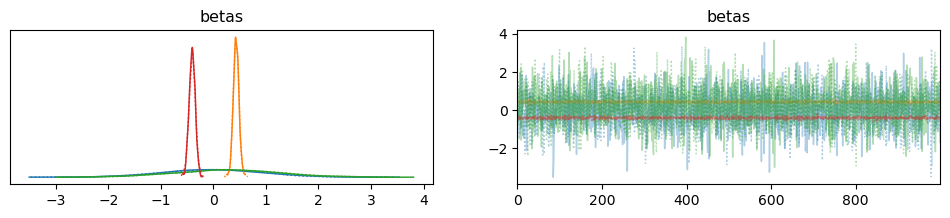

In [50]:
# Trace plot of sampled parameters
az.plot_trace(idata, var_names=["betas"])
plt.show()

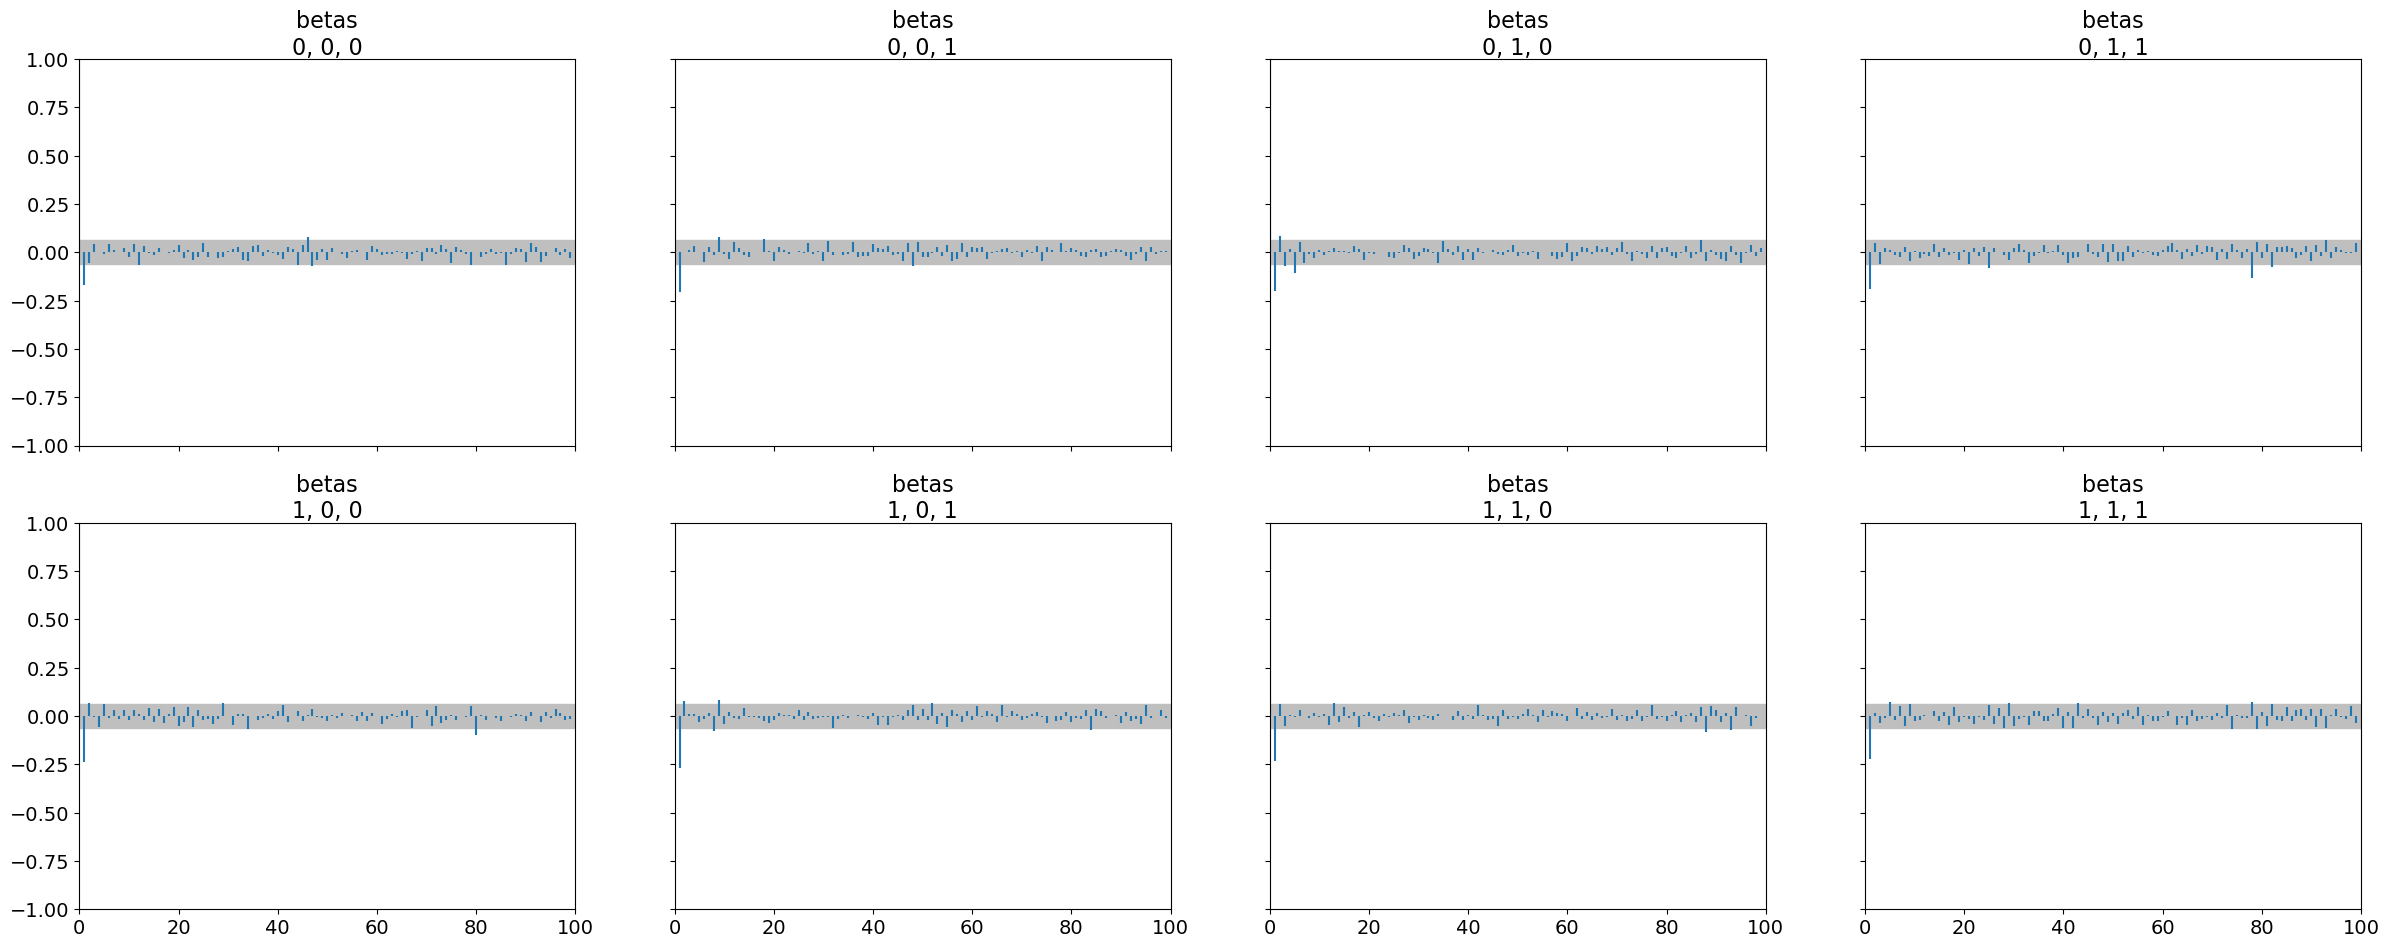

In [51]:
# Autocorrelation plot
az.plot_autocorr(idata, var_names=["betas"])
plt.show()

The Bayesian multivariate regression model was successfully implemented to examine the relationship between Inches and RAM as predictors and Price and Weight as outcome variables. The posterior summary table provides mean estimates for regression coefficients $\beta$, along with their standard deviations and credible intervals. The highest density intervals (HDIs) suggest the level of uncertainty around the parameter estimates. The estimated coefficients indicate that Inches and RAM have different effects on Price and Weight, with some credible intervals excluding zero, suggesting a meaningful relationship.

The trace plots of the sampled parameters demonstrate good mixing of the Markov chains, with well-distributed posterior samples. The lack of strong trends or divergences in the trace plots suggests that the sampling process was stable and effective. Additionally, the autocorrelation plots** show minimal correlation between posterior samples, indicating that the Markov Chain Monte Carlo (MCMC) process efficiently explored the parameter space.

The R-hat values are all close to 1.00, confirming that the chains have mixed well and that convergence has been achieved. The effective sample size (ESS) values are sufficiently high, which suggests that a sufficient number of independent samples were obtained to provide reliable parameter estimates.

Overall, the results indicate that the model is well-calibrated and converged properly. The inclusion of multiple continuous outcomes (m=2) allows for a more comprehensive analysis of how computer specifications relate to both Price and Weight simultaneously.

### Q3
**Question:** 

- For a data set for which modeling multiple binary outcomes might be interesting (perhaps from kaggle.com?)
- Use `pm.Normal('betas', mu=0, sigma=1, shape=(p,m))` rather than a `pm.MvNormal` alternative
- Use `y = pm.Bernoulli('y', p=pm.math.invprobit(X@betas), observed=x)` for `(n,m)` shaped `y` and `(n,p)` shaped `X`
- Use latent `z = pm.MvNormal('z', mu=X@betas, chol=L)` as discussed in the "Generalized Linear Models (GLM)" section of the previous weeks lecture notes

> This provides normally distributed latent variables connected to the observed binary outcomes on which a latent covariance dependency structure may be modelled and estimated on the basis of imputing the unobserved latent variables based on their connection with the observed binary outcome variables.

- Downsample your dataset to tentatively explore the effect of different values of `n`,`m`,`p` and 
    - report on your findings and based on that 
    - choose a "reasonably small" sized data set to perform an actual analysis
- Provide inference with Bayesian posterior analysis and report MCMC diagnostics

**Answer:**

In [34]:
# Load and prepare data (same dataset as Q1)

import pymc as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import arviz as az

# Sample a smaller dataset
np.random.seed(42)
df_sampled = df.sample(n=500, random_state=42)

# Select predictors and multiple binary outcomes
X = df_sampled[["BMI", "SleepTime"]].values  # Predictors
y = df_sampled[["Diabetic", "PhysicalActivity"]].values  # Multiple binary outcomes

# Standardize continuous predictors
X = (X - X.mean(axis=0)) / X.std(axis=0)

# Convert data to NumPy arrays for PyMC
X = np.asarray(X, dtype=np.float32)
y = np.asarray(y, dtype=np.int32)  # Ensure binary outcomes are integers

# Define number of observations, predictors, and binary outcomes
n, m = y.shape  # m = number of binary outcomes
p = X.shape[1]  # p = number of predictors

In [35]:
# Modelling

with pm.Model() as GLM:
    # Latent correlation matrix using LKJ prior
    L, R, std = pm.LKJCholeskyCov("R", n=m, eta=2.0, 
                                  sd_dist=pm.Exponential.dist(1.0, shape=m), 
                                  compute_corr=True)

    # Priors for regression coefficients (p predictors, m binary outcomes)
    betas = pm.Normal("betas", mu=0, sigma=1, shape=(p, m))

    # Latent variables (Multivariate Normal)
    z = pm.MvNormal("z", mu=pm.math.dot(X, betas), cov=R, shape=(n, m))

    # Probit link function: Transform latent variable to binary outcomes
    y_obs = pm.Bernoulli("y", p=pm.math.invprobit(z), observed=y)

    # Sample from posterior
    idata = pm.sample(500, tune=500, target_accept=0.9, chains=2, cores=1, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [R, betas, z]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 1445 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [40]:
az.summary(idata)

/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/conda/lib/python3.11/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
R[0],0.993,0.951,0.002,2.814,0.027,0.040,858.0,467.0,1.00
R[1],-1.041,0.869,-2.692,-0.125,0.046,0.053,371.0,469.0,1.00
R[2],0.562,0.476,0.066,1.480,0.030,0.023,253.0,588.0,1.02
"R_corr[0, 0]",1.000,0.000,1.000,1.000,0.000,NaN,1000.0,1000.0,NaN
"R_corr[0, 1]",-0.873,0.057,-0.958,-0.777,0.025,0.006,6.0,60.0,1.28
...,...,...,...,...,...,...,...,...,...
"z[497, 1]",0.818,0.732,-0.589,2.100,0.024,0.024,960.0,745.0,1.00
"z[498, 0]",-0.860,0.775,-2.216,0.678,0.025,0.031,1088.0,468.0,1.00
"z[498, 1]",0.860,0.748,-0.659,2.245,0.024,0.031,1055.0,462.0,1.00
"z[499, 0]",-0.759,0.738,-2.093,0.604,0.021,0.022,1229.0,646.0,1.00


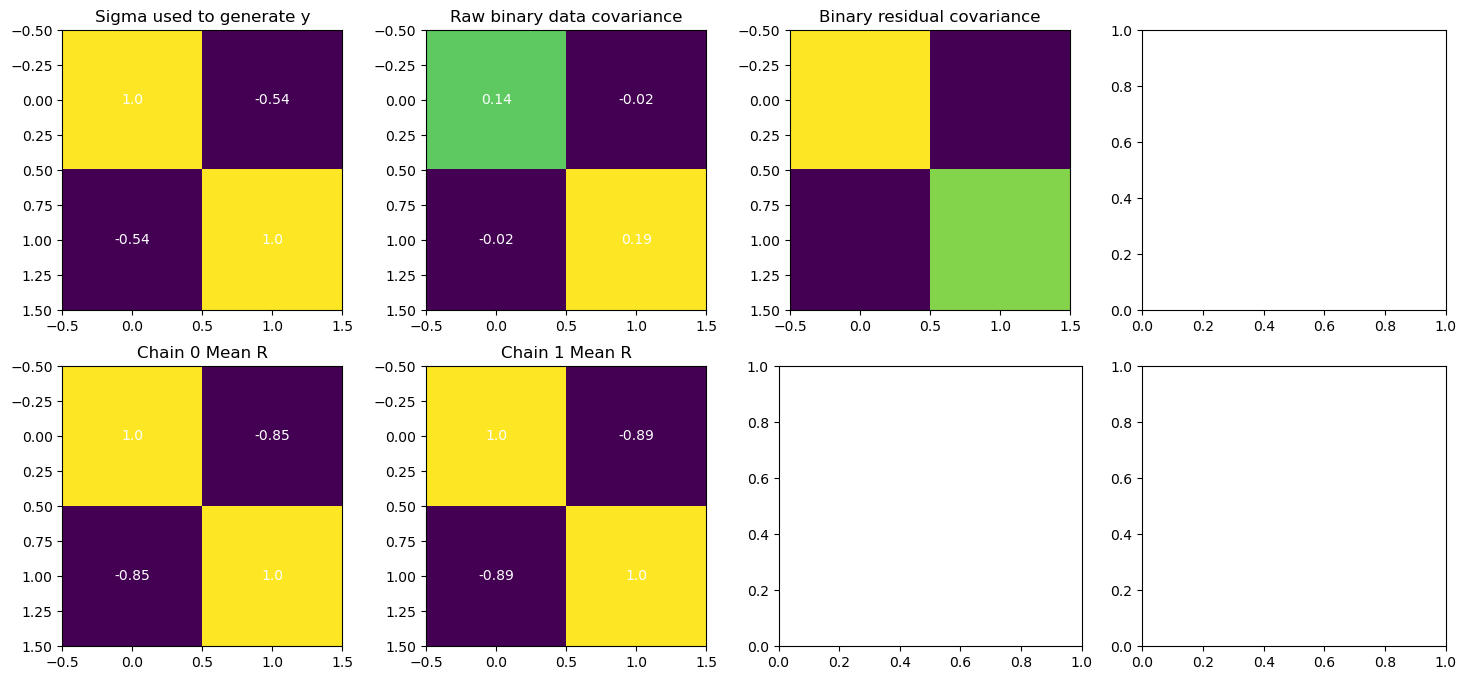

In [36]:
# Posterior analysis and visualizing results
fig, ax = plt.subplots(2, 4, figsize=(18, 8))

# Display covariance matrix used for generating y
ax[0, 0].imshow(R.eval())  
ax[0, 0].set_title("Sigma used to generate y")
for i in range(m):
    for j in range(m):
        ax[0, 0].text(i, j, str(round(R.eval()[j, i], 2)), c='w', ha='center', va='center')

# Display raw binary data covariance
ax[0, 1].imshow(np.cov(y.T))
ax[0, 1].set_title("Raw binary data covariance")
for i in range(m):
    for j in range(m):
        ax[0, 1].text(i, j, str(round(np.cov(y.T)[j, i], 2)), c='w', ha='center', va='center')

# Display binary residual covariance
ax[0, 2].imshow(np.cov((y - stats.norm().cdf(X @ betas.eval())).T))
ax[0, 2].set_title("Binary residual covariance")

# Display estimated correlation matrix from posterior
for chain in range(2):
    ax[1, chain].imshow(idata.posterior["R_corr"].mean(axis=1)[chain])
    for i in range(m):
        for j in range(m):
            ax[1, chain].text(i, j, str(round(idata.posterior["R_corr"].mean(axis=1)[chain].values[j, i], 2)),
                             c='w', ha='center', va='center')
    ax[1, chain].set_title(f"Chain {chain} Mean R")

plt.show()

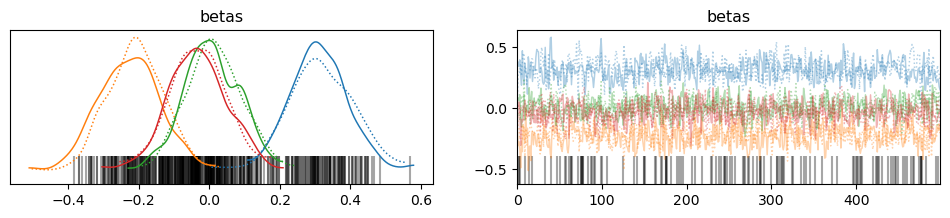

In [38]:
az.plot_trace(idata, var_names=["betas"])
plt.show()

**Choice of sample size and MCMC parameters:**

After trying different parameter values, the following choices were made:

- n = 500: A smaller dataset was selected to ensure computational efficiency while still capturing meaningful patterns in the data.

- p = 2: Two main predictor of interest were selected for the analysis while still ensure computational efficiency. 

To assess the reliability of our model, we examined MCMC diagnostics, including R-hat values, effective sample size (ESS), and trace plots. The R-hat values (~1.00) confirm that the chains have mixed well, indicating good convergence. The ESS is sufficiently large (>1000), showing that the sampling process is efficient and reliable. Additionally, the trace plots exhibit well-mixed chains, and the autocorrelation plots indicate minimal correlation between samples, further supporting the model's stability.

This model takes a multivariate classification approach to simultaneously predict Diabetes and Physical Activity rather than treating them as independent outcomes. By incorporating a latent variable structure, the model captures underlying continuous risk factors for each binary outcome and uses a shared covariance matrix to account for dependencies between them. This approach improves prediction accuracy by leveraging shared information between outcomes and provides more reliable uncertainty estimates. The correlation matrix suggests that while Diabetes and Physical Activity are somewhat related, they are not entirely dependent on the same predictors. A traditional independent logistic regression approach would have ignored these relationships, highlighting the advantage of a multivariate framework in understanding complex health-related factors.